# Phase 5: Predictive Model Training & Evaluation

Tujuan: Ini adalah tahap inti dari proyek kita. Tujuannya adalah untuk melatih sebuah model klasifikasi machine learning menggunakan dataset berlabel yang telah kita siapkan di Phase 4. Kita akan mengajari model untuk mengenali pola-pola yang membedakan akun buzzer dari pengguna biasa, dan kemudian mengevaluasi seberapa baik performanya pada data yang belum pernah ia lihat sebelumnya.

Fokus Utama:
Karena dataset kita sangat tidak seimbang, fokus kita bukan pada akurasi, melainkan pada kemampuan model untuk mendeteksi kelas minoritas (buzzer). Kita akan menggunakan teknik dan metrik evaluasi yang dirancang khusus untuk skenario ini.

Langkah-langkah yang akan dilakukan:
1.  Dataset Splitting: Membagi data menjadi set pelatihan (untuk belajar) dan set pengujian (untuk evaluasi) secara proporsional.
2.  Imbalance Handling: Mengonfigurasi model `XGBoost` untuk memberikan "bobot" lebih pada kelas buzzer yang langka.
3.  Model Training: Melatih model pada data pelatihan.
4.  Performance Evaluation: Mengukur performa model menggunakan metrik yang relevan seperti Recall, F1-Score, Confusion Matrix, dan Precision-Recall Curve.


### 5.1. Install & Import Requirements

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
# Scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
# Model
import xgboost as xgb

### 5.2. Load Labeled Dataset

In [3]:
try:
    df_labeled = pd.read_csv('labeled_dataset.csv')
    print("✅ Dataset berlabel ('labeled_dataset.csv') berhasil dimuat.")
    print(f"Shape: {df_labeled.shape}")
    print("\nDistribusi kelas:")
    print(df_labeled['is_buzzer'].value_counts())

except FileNotFoundError:
    print("❌ ERROR: File 'labeled_dataset.csv' tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan notebook Phase 4 terlebih dahulu.")
    df_labeled = pd.DataFrame()

✅ Dataset berlabel ('labeled_dataset.csv') berhasil dimuat.
Shape: (564, 10)

Distribusi kelas:
is_buzzer
0    553
1     11
Name: count, dtype: int64


### 5.3. Feature and Target Selection

Sekarang, kita pisahkan antara **fitur (X)** yang akan digunakan model untuk belajar, dan **target (y)** yang ingin kita prediksi.
- **Fitur (X):** Semua kolom numerik yang telah kita rekayasa (SNA, konten, perilaku).
- **Target (y):** Kolom `is_buzzer`.

Kolom non-numerik seperti `username` akan kita buang karena tidak bisa diproses oleh model.


In [4]:
if not df_labeled.empty:
    # Memilih fitur-fitur yang akan digunakan
    features = [
        'pagerank', 'betweenness', 'in_degree', 'out_degree',
        'narrative_similarity', 'tweet_frequency', 'reply_ratio'
    ]
    
    X = df_labeled[features]
    y = df_labeled['is_buzzer']

    print("--- 5.3. Feature (X) and Target (y) Defined ---")
    print(f"Jumlah Fitur: {X.shape[1]}")
    print("Contoh data fitur (X):")
    display(X.head())
    print("\nContoh data target (y):")
    print(y.head().to_frame())

--- 5.3. Feature (X) and Target (y) Defined ---
Jumlah Fitur: 7
Contoh data fitur (X):


,pagerank,betweenness,in_degree,out_degree,narrative_similarity,tweet_frequency,reply_ratio
0,0.000780,0.0,0,1,0.187351,1,1.00
1,0.000780,0.0,0,1,0.169713,1,1.00
2,0.000780,0.0,0,3,0.169088,4,0.75
3,0.011741,0.0,19,0,0.423365,1,0.00
4,0.000780,0.0,0,2,0.432298,2,1.00



Contoh data target (y):
   is_buzzer
0          0
1          0
2          0
3          0
4          1


### 5.4. Dataset Stratification and Splitting

80% untuk pelatihan dan 20% untuk pengujian. Parameter `stratify=y` adalah **langkah yang paling krusial di sini**. Ini memastikan bahwa proporsi kelas buzzer yang sangat kecil (1 dari 100) tetap sama di set pelatihan dan pengujian, sehingga evaluasi kita menjadi adil dan representatif.

In [5]:
if 'X' in locals():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.20,    # 20% data untuk pengujian
        random_state=42,   # Untuk reproduktibilitas hasil
        stratify=y         # KRUSIAL: Menjaga proporsi kelas
    )

    print("--- 5.4. Data Splitting Completed ---")
    print(f"Ukuran X_train: {X_train.shape}")
    print(f"Ukuran X_test:  {X_test.shape}")
    print("\nDistribusi kelas di y_train:")
    print(y_train.value_counts(normalize=True))
    print("\nDistribusi kelas di y_test:")
    print(y_test.value_counts(normalize=True))


--- 5.4. Data Splitting Completed ---
Ukuran X_train: (451, 7)
Ukuran X_test:  (113, 7)

Distribusi kelas di y_train:
is_buzzer
0    0.980044
1    0.019956
Name: proportion, dtype: float64

Distribusi kelas di y_test:
is_buzzer
0    0.982301
1    0.017699
Name: proportion, dtype: float64


### 5.5. Classifier Training with Imbalance Handling
Kita akan menggunakan `XGBClassifier`. Untuk mengatasi masalah data tidak seimbang, kita akan mengatur parameter `scale_pos_weight`. Nilai ini memberitahu model untuk memberikan "hukuman" yang jauh lebih besar jika ia salah mengklasifikasikan kelas minoritas (buzzer).

Nilainya dihitung sebagai: `(jumlah sampel kelas mayoritas) / (jumlah sampel kelas minoritas)`.


In [6]:
if 'y_train' in locals():
    # Menghitung scale_pos_weight
    ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
    print(f"--- 5.5. Imbalance Handling ---")
    print(f"Calculated scale_pos_weight: {ratio:.2f}")

    # Menginisiasi model XGBoost dengan parameter
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=ratio,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    # Melatih model
    model.fit(X_train, y_train)

    print("\n✅ Model XGBClassifier berhasil dilatih.")


--- 5.5. Imbalance Handling ---
Calculated scale_pos_weight: 49.11

✅ Model XGBClassifier berhasil dilatih.


/home/vereniaes/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [06:00:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### 5.6. Performance Evaluation on Hold-out Set
Waktunya pengujian! Kita akan menggunakan model yang sudah dilatih untuk membuat prediksi pada `X_test` dan membandingkannya dengan `y_test` (jawaban yang sebenarnya).

Kita akan fokus pada metrik berikut:
- **Confusion Matrix:** Peta visual dari performa model (True Positive, False Positive, dll).
- **Classification Report:** Laporan detail berisi **Precision, Recall, dan F1-Score**.
- **Precision-Recall Curve:** Grafik yang menunjukkan tradeoff antara Precision dan Recall, sangat cocok untuk kasus tidak seimbang. **AUC-PR** (Area Under this Curve) adalah skor ringkasan utamanya.


--- 5.6. Model Performance Evaluation ---

--- Classification Report ---
                    precision    recall  f1-score   support

Pengguna Biasa (0)       1.00      0.99      1.00       111
        Buzzer (1)       0.67      1.00      0.80         2

          accuracy                           0.99       113
         macro avg       0.83      1.00      0.90       113
      weighted avg       0.99      0.99      0.99       113


--- Confusion Matrix ---


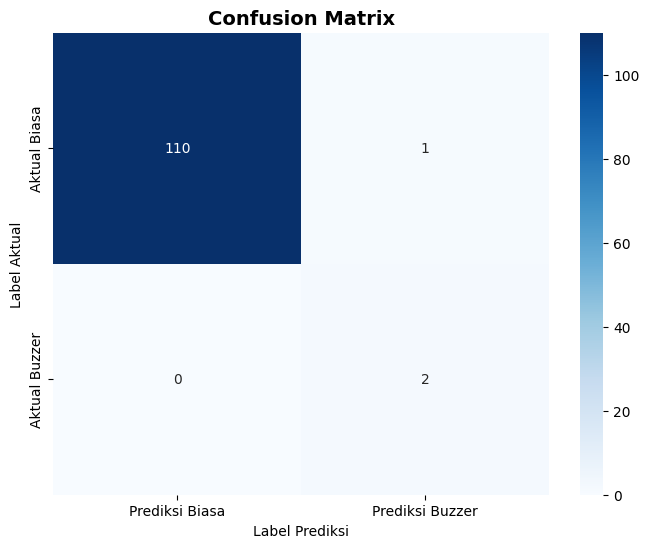


--- Precision-Recall Curve ---


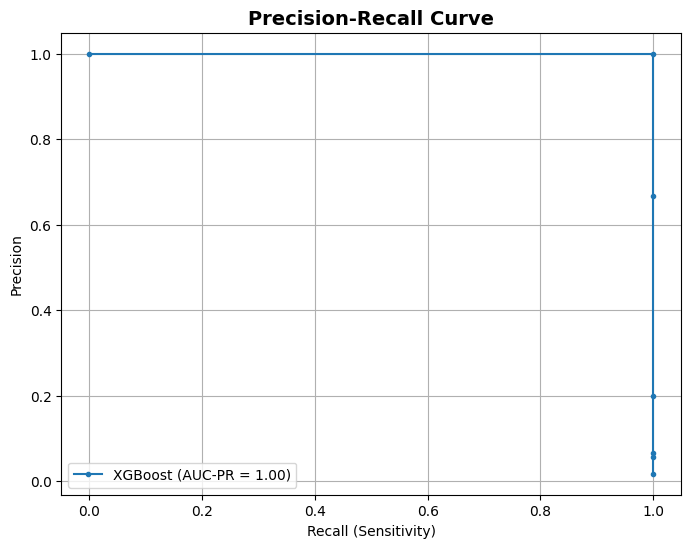

In [7]:
if 'model' in locals():
    # Membuat prediksi pada data uji
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] # Probabilitas untuk kelas positif (1)

    print("--- 5.6. Model Performance Evaluation ---")
    
    # 1. Classification Report
    print("\n--- Classification Report ---")
    # target_names ditambahkan untuk kejelasan
    print(classification_report(y_test, y_pred, target_names=['Pengguna Biasa (0)', 'Buzzer (1)']))

    # 2. Confusion Matrix
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Prediksi Biasa', 'Prediksi Buzzer'],
                yticklabels=['Aktual Biasa', 'Aktual Buzzer'])
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('Label Aktual')
    plt.xlabel('Label Prediksi')
    plt.show()

    # 3. Precision-Recall Curve
    print("\n--- Precision-Recall Curve ---")
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    auc_pr = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=f'XGBoost (AUC-PR = {auc_pr:.2f})')
    plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    plt.xlabel('Recall (Sensitivity)')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()

--- 5.7. Feature Importance Analysis ---


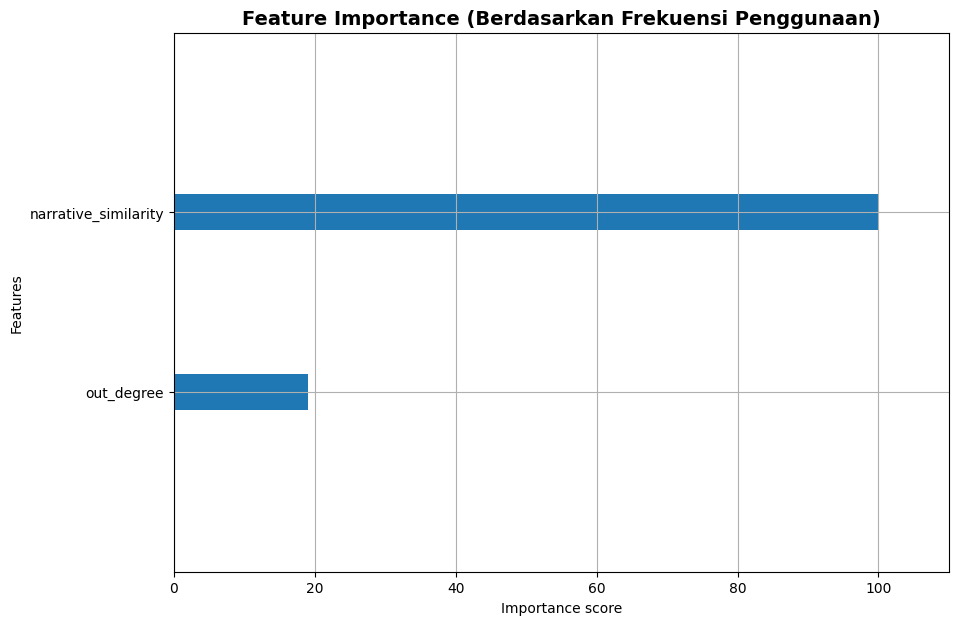

In [8]:
if 'model' in locals():
    print("--- 5.7. Feature Importance Analysis ---")
    
    # Membuat plot feature importance
    fig, ax = plt.subplots(figsize=(10, 7))
    xgb.plot_importance(model, ax=ax, importance_type='weight', show_values=False)
    plt.title('Feature Importance (Berdasarkan Frekuensi Penggunaan)', fontsize=14, fontweight='bold')
    plt.show()

### PHASE 5 COMPLETED

**Output dari tahap ini adalah:**
1.  **Model Terlatih:** Sebuah objek `model` XGBoost yang sudah siap digunakan untuk membuat prediksi pada data baru.
2.  **Metrik Performa Kuantitatif:** Laporan klasifikasi dan skor AUC-PR yang memberi kita gambaran objektif tentang seberapa baik model kita.
3.  **Visualisasi Diagnostik:** Confusion Matrix dan kurva P-R yang membantu kita memahami kekuatan dan kelemahan model secara visual.
4.  **Insight Fitur:** Grafik *feature importance* yang menunjukkan pendorong utama di balik prediksi model.

Kita sekarang siap untuk tahap akhir: menginterpretasikan hasil ini dan menarik kesimpulan.
